# Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import time
import json
import numpy as np
import pandas as pd
import xarray as xr
import xskillscore as xs

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.stats import norm
from xskillscore import crps_quadrature, crps_ensemble

import sys
sys.path.append('/'.join(sys.path[0].split('/')[:-1]))
from modules.architectures import *

from modules.swag import data, models, utils, losses
from modules.swag.posteriors import SWAG

import modules.architectures as modelArchitectures
from modules.full_pipeline import compute_errors, _inner
from modules.plotting import plot_intervalmap, plot_signal
from modules.data import hp_to_equiangular
from modules.test import compute_rmse_healpix, compute_R2

# RMSE Comparison of Deep Ensemble Members

In [3]:
description_epoch = 'all_const_len2_delta_6_architecture_loss_v0_2steps_constant_increasing_static_l3_long_connections_per_epoch'
figures_path = '../data/healpix/figures/' + description_epoch + '/'

config_file = 'config_s01_two_steps_small.json'

with open("../configs/" + config_file) as json_data_file:
        cfg = json.load(json_data_file)

# Define paths
datadir = cfg['directories']['datadir']
input_dir = datadir + cfg['directories']['input_dir']
model_save_path = datadir + cfg['directories']['model_save_path']
pred_save_path = datadir + cfg['directories']['pred_save_path']
metrics_path = datadir + cfg['directories']['metrics_path']

resolution = cfg['model_parameters']['resolution']
max_lead_time = cfg['training_constants']['max_lead_time']

lead_time = 6
lead_times = np.arange(lead_time, max_lead_time+lead_time, lead_time)

## Random train/val split

In [4]:
compute = False

In [5]:
obs = xr.open_mfdataset(pred_save_path + 'observations_nearest.nc', combine='by_coords')
description = "all_const_len2_delta_6_architecture_loss_v0_2steps_constant_increasing_static_l3_long_connections_per_epoch"

# Ensemble models
filename_ens = description + f'_s02_ensemble'
rmses = []
for i in range(10):
    description_model = filename_ens + f'_model{i+1}_epoch11'
    rmse_filename = datadir + 'metrics/rmse_' + description_model + '.nc'
    if compute:
        ens_model = xr.open_dataset(pred_save_path + description_model + '.nc').chunk('auto')
        rmse = compute_rmse_healpix(ens_model, obs).load()
        rmse.to_netcdf(rmse_filename)
    else:
        rmse = xr.open_dataset(rmse_filename)
    rmses.append(rmse)
    
    del rmse

# Classic training
filename_classic = datadir + 'metrics/rmse_' + description + "_s02_epoch_11.nc"
classic = xr.open_dataset(filename_classic)

# Ensemble median
filename_median = datadir + 'metrics/rmse_' + description + f'_s02_ensemble_epoch_11_median.nc'
ens_median = xr.open_dataset(filename_median)

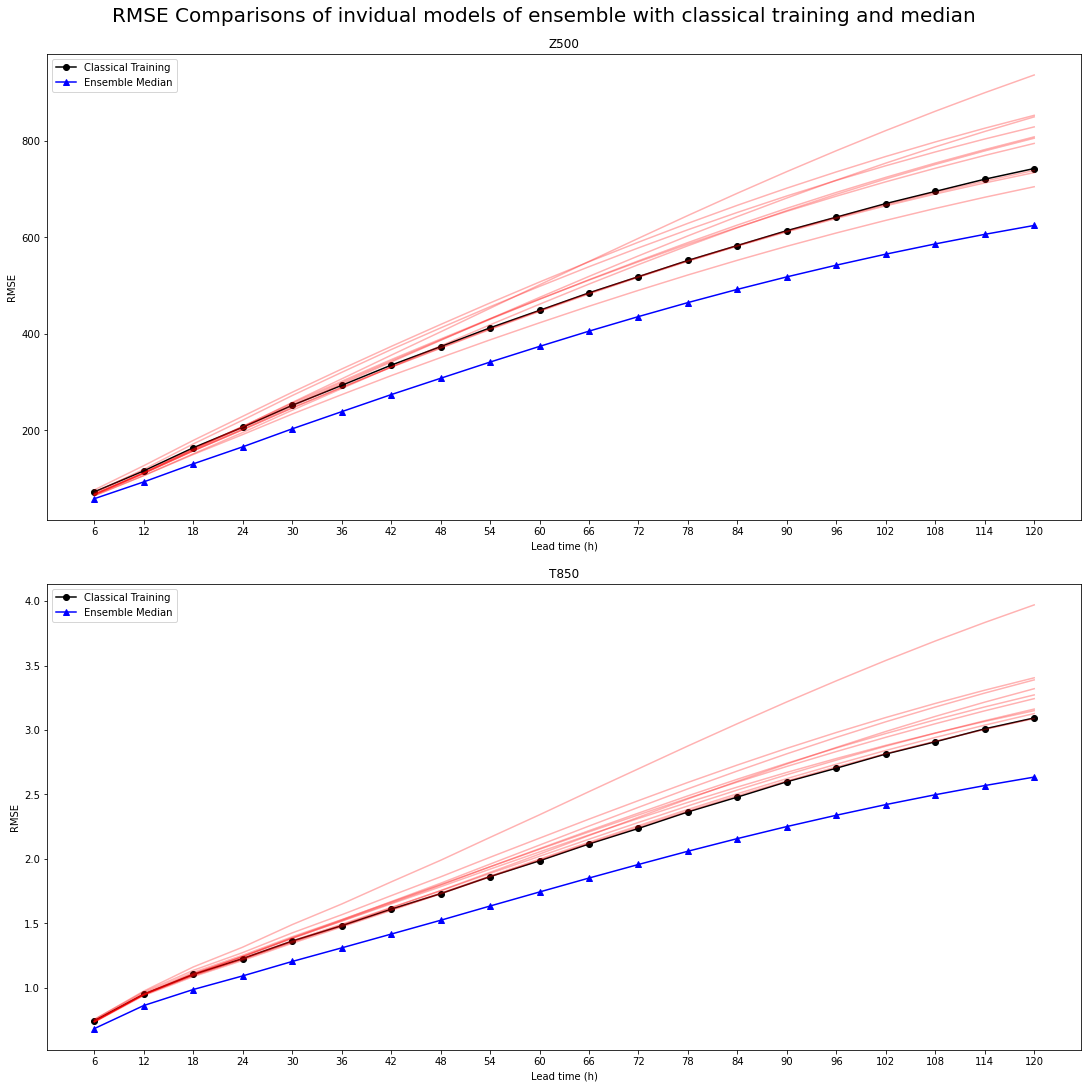

In [6]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15), constrained_layout=True)
    
lead_times = np.arange(lead_time, max_lead_time + lead_time, lead_time)


ax1.plot(lead_times, classic.z.values, color='black', marker='o', label='Classical Training')
ax1.plot(lead_times, ens_median.z.values, color='blue', marker='^', label='Ensemble Median')
for i, rmse in enumerate(rmses):
    ax1.plot(lead_times, rmse.z.values, color='red', alpha=0.3)
    
ax2.plot(lead_times, classic.t.values, color='black', marker='o', label='Classical Training')
ax2.plot(lead_times, ens_median.t.values, color='blue', marker='^', label='Ensemble Median')
for i, rmse in enumerate(rmses):
    ax2.plot(lead_times, rmse.t.values, color='red', alpha=0.3)

ax1.set_xlabel('Lead time (h)')
ax1.set_xticks(lead_times)
ax2.set_xticks(lead_times)
ax2.set_xlabel('Lead time (h)')
ax1.set_ylabel('RMSE')
ax2.set_ylabel('RMSE')
ax1.set_title('Z500')
ax2.set_title('T850')

f.suptitle('RMSE Comparisons of invidual models of ensemble with classical training and median', fontsize=20)
ax1.legend()
ax2.legend()
plt.show()

## Fixed train/val split

In [7]:
compute = False

In [8]:
obs = xr.open_mfdataset(pred_save_path + 'observations_nearest.nc', combine='by_coords')
description = "all_const_len2_delta_6_architecture_loss_v0_2steps_constant_increasing_static_l3_long_connections_per_epoch"

# Ensemble models
filename_ens = description + f'_s02_fixed_data_ensemble_ensemble'
rmses = []
for i in range(10):
    description_model = filename_ens + f'_model{i+1}_epoch11'
    rmse_filename = datadir + 'metrics/rmse_' + description_model + '.nc'
    if compute:
        ens_model = xr.open_dataset(pred_save_path + description_model + '.nc').chunk('auto')
        rmse = compute_rmse_healpix(ens_model, obs).load()
        rmse.to_netcdf(rmse_filename)
    else:
        rmse = xr.open_dataset(rmse_filename)
    rmses.append(rmse)
    
    del rmse

# Classic training
filename_classic = datadir + 'metrics/rmse_' + description + "_s02_epoch_11.nc"
classic = xr.open_dataset(filename_classic)

# Ensemble median
filename_median = datadir + 'metrics/rmse_' + description + f'_s02_fixed_data_ensemble_ensemble_epoch_11_median.nc'
ens_median = xr.open_dataset(filename_median)

In [9]:
# Ensemble models
filename_ens = description + f'_s02_ensemble'
rmses_ens_rand = []
for i in range(10):
    description_model = filename_ens + f'_model{i+1}_epoch11'
    rmse_filename = datadir + 'metrics/rmse_' + description_model + '.nc'
    rmse = xr.open_dataset(rmse_filename)
    rmses_ens_rand.append(rmse)
    
    del rmse

# Ensemble median
filename_median = datadir + 'metrics/rmse_' + description + f'_s02_ensemble_epoch_11_median.nc'
ens_median_rand = xr.open_dataset(filename_median)

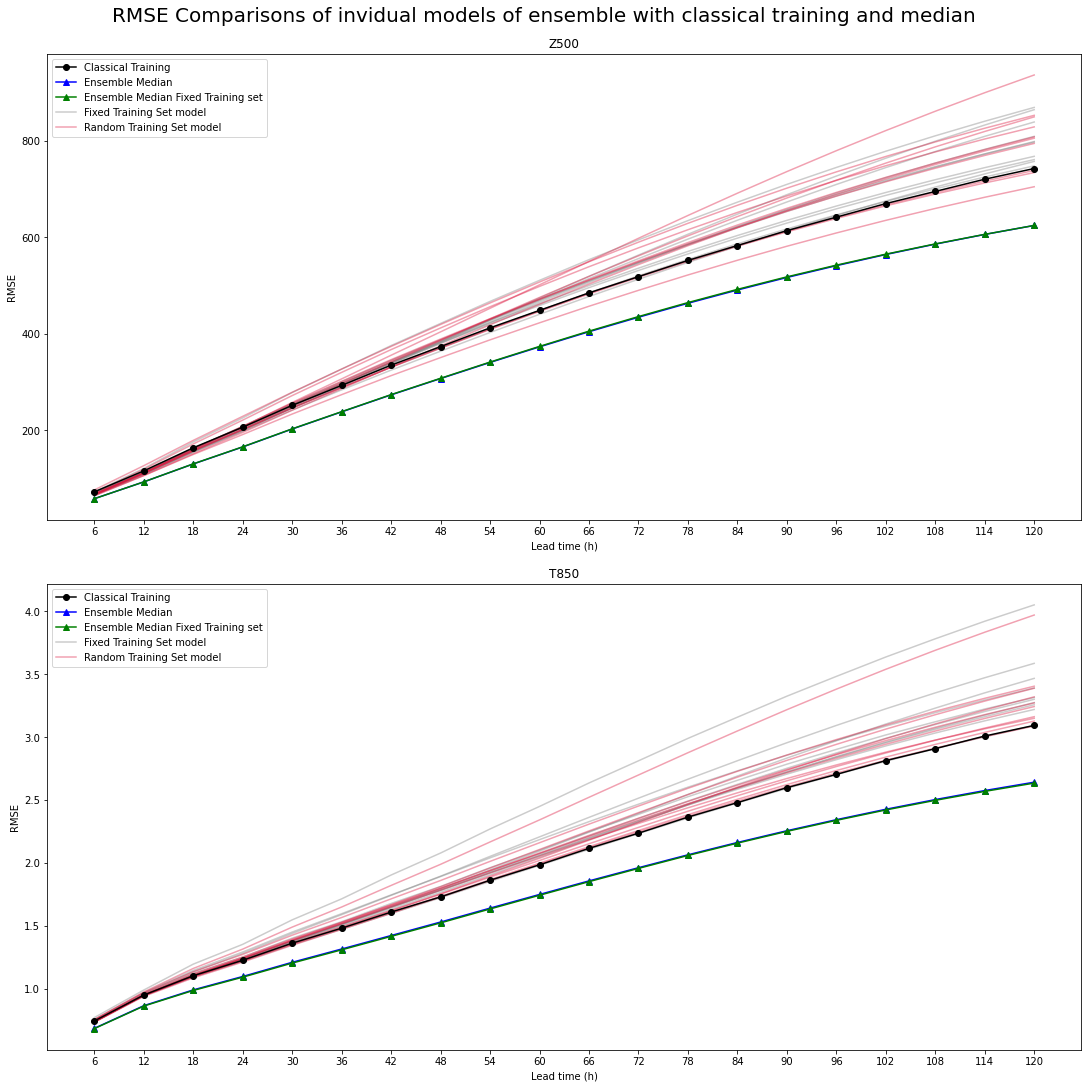

In [10]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15), constrained_layout=True)
    
lead_times = np.arange(lead_time, max_lead_time + lead_time, lead_time)


ax1.plot(lead_times, classic.z.values, color='black', marker='o', label='Classical Training')
ax1.plot(lead_times, ens_median.z.values, color='blue', marker='^', label='Ensemble Median')
ax1.plot(lead_times, ens_median_rand.z.values, color='green', marker='^', label='Ensemble Median Fixed Training set')
for i, rmse in enumerate(rmses):
    ax1.plot(lead_times, rmse.z.values, color='grey', alpha=0.4, label='Fixed Training Set model', zorder=-32)
for i, rmse in enumerate(rmses_ens_rand):
    ax1.plot(lead_times, rmse.z.values, color='crimson', alpha=0.4, label='Random Training Set model', zorder=-32)
    
ax2.plot(lead_times, classic.t.values, color='black', marker='o', label='Classical Training')
ax2.plot(lead_times, ens_median.t.values, color='blue', marker='^', label='Ensemble Median')
ax2.plot(lead_times, ens_median_rand.t.values, color='green', marker='^', label='Ensemble Median Fixed dataset')
for i, rmse in enumerate(rmses):
    ax2.plot(lead_times, rmse.t.values, color='gray', alpha=0.4, label='Fixed Training Set model', zorder=-32)
for i, rmse in enumerate(rmses_ens_rand):
    ax2.plot(lead_times, rmse.t.values, color='crimson', alpha=0.4, label='Random Training Set model', zorder=-32)

ax1.set_xlabel('Lead time (h)')
ax1.set_xticks(lead_times)
ax2.set_xticks(lead_times)
ax2.set_xlabel('Lead time (h)')
ax1.set_ylabel('RMSE')
ax2.set_ylabel('RMSE')
ax1.set_title('Z500')
ax2.set_title('T850')

f.suptitle('RMSE Comparisons of invidual models of ensemble with classical training and median', fontsize=20)

display = [0, 1, 2, 3, 13]
handles, labels = ax1.get_legend_handles_labels()
ax1.legend([handle for i,handle in enumerate(handles) if i in display],
           [label for i,label in enumerate(labels) if i in display], loc = 'best')
ax2.legend([handle for i,handle in enumerate(handles) if i in display],
           [label for i,label in enumerate(labels) if i in display], loc = 'best')
plt.show()